In [1]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nsec.models.dae.convdae import SmallUResNet

In [3]:
import tensorflow_datasets as tfds
from jax.experimental import optix
import jax.numpy as jnp
from nsec.normalization import SNParamsTree as CustomSNParamsTree

import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions

In [4]:
import haiku as hk

In [5]:
# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

In [6]:
# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.pad(train_images,((0,0),(2,2),(2,2),(0,0)))/255.

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.pad(test_images, ((0,0),(2,2),(2,2),(0,0)))/255.

In [7]:
def forward(x, s, is_training=False):
    denoiser = SmallUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [8]:
import jax 
rng_seq = hk.PRNGSequence(42)

In [9]:
# Importing saved model
import pickle
with open('conv-dae-L2.pckl', 'rb') as file:
    params, state, sn_state = pickle.load(file)

In [10]:
from functools import partial
score = partial(model.apply, params, state, next(rng_seq))

In [11]:
# Trying to sample from the model
from nsec.samplers import ScoreHamiltonianMonteCarlo

In [12]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax

def score_fn(x, sigma):
    return score(x.reshape((-1,32,32,1)), sigma.reshape((-1,1,1,1)), is_training=False)[0].reshape((-1, 32*32))

In [13]:
num_results = int(1e3)
num_burnin_steps = int(1e0)

In [14]:
init_image=0.5*randn(16,32,32).reshape((-1, 32*32,)).astype('float32')

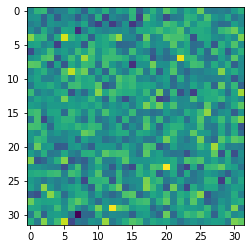

In [15]:
imshow(init_image[0].reshape((32,32)))

In [16]:
from nsec.tempered_sampling import TemperedMC

In [ ]:
def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=np.max(sigma)**0.9/(0.02**0.9)*0.0005,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=score_fn,
            inverse_temperatures=0.5*np.ones([16]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.97,
            min_steps_per_temp=20,
            num_delta_logp_steps=4)

num_results = int(1e4)
num_burnin_steps = int(1)

samples, trace = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=init_image,
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures),
        seed=jax.random.PRNGKey(0))

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


[Traced<ShapedArray(float32[16,1024]):JaxprTrace(level=1/0)>]


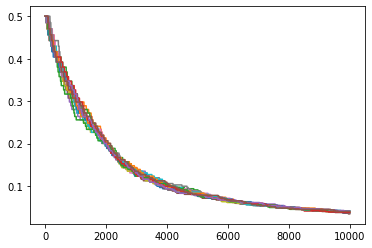

In [74]:
plot(trace[1]);

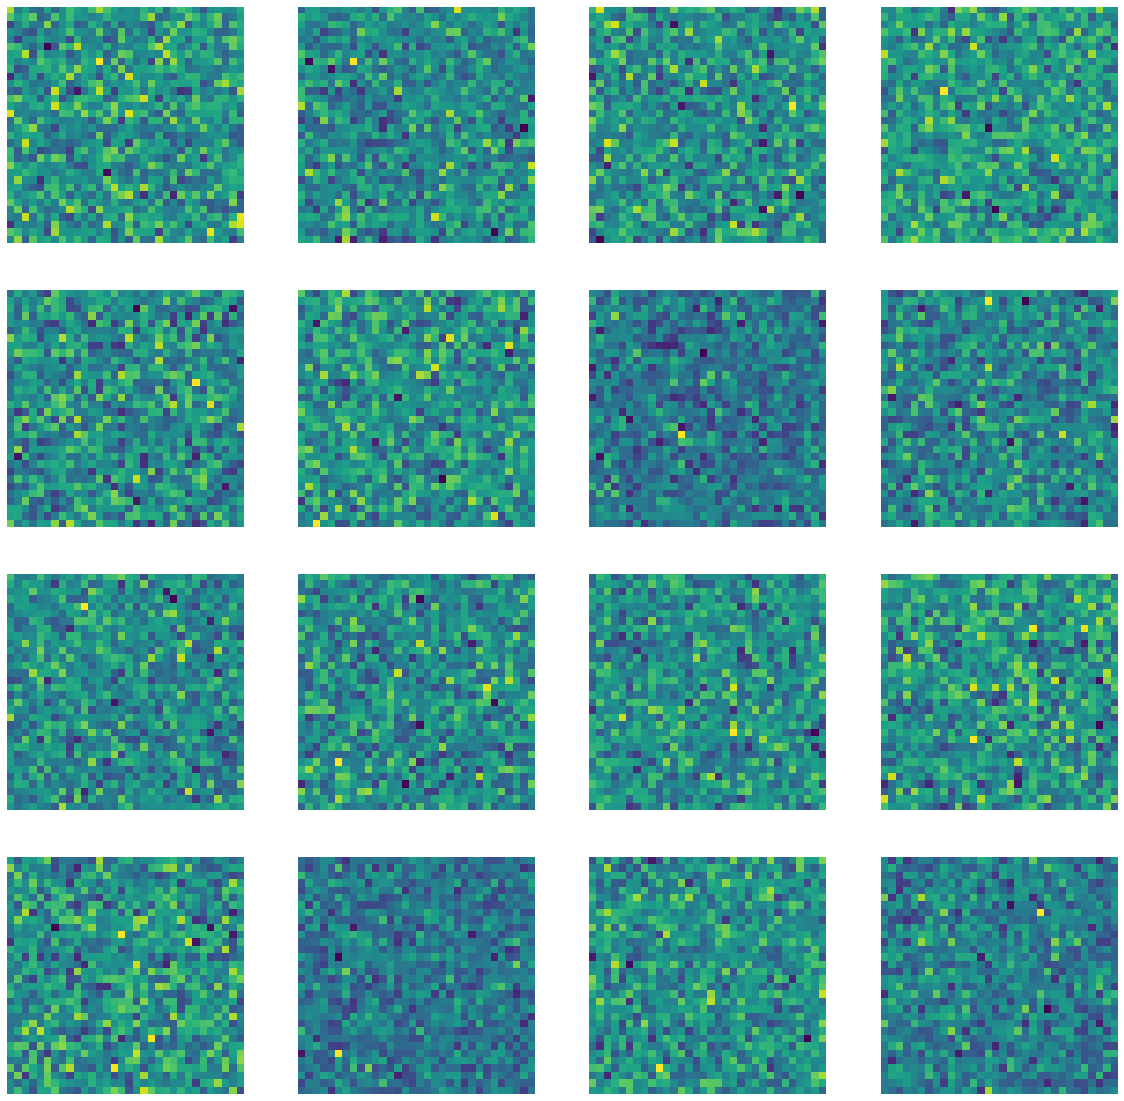

In [75]:
figure(figsize=(20,20))
for i in range(4):
  for j in range(4):
    subplot(4,4,4*i+j+1)
    imshow(samples[0,(4*i+j)].reshape((32,32)))
    axis('off')

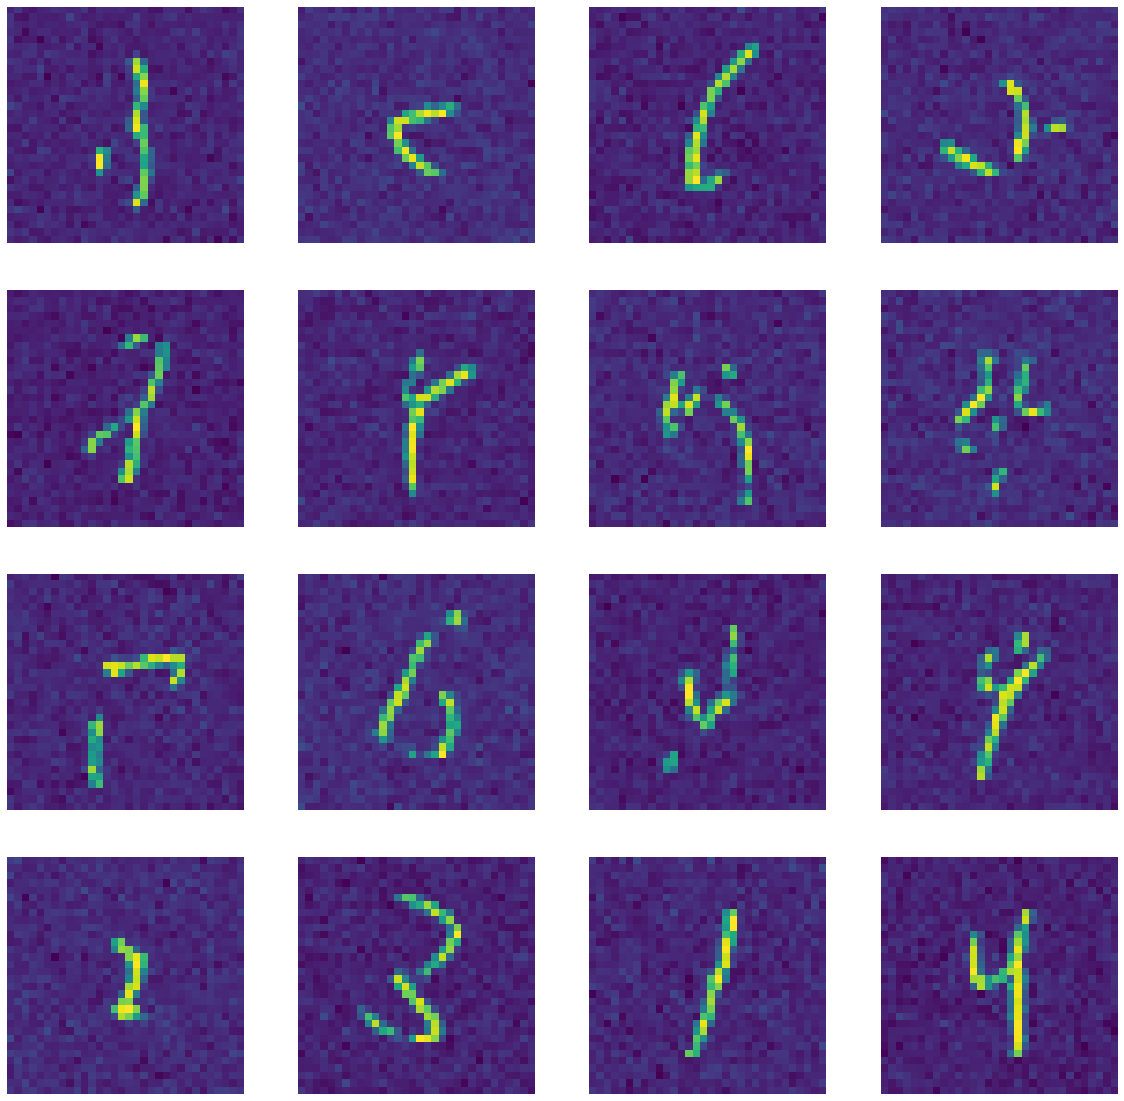

In [76]:
figure(figsize=(20,20))
for i in range(4):
  for j in range(4):
    subplot(4,4,4*i+j+1)
    imshow(samples[-1,(4*i+j)].reshape((32,32)))
    axis('off')

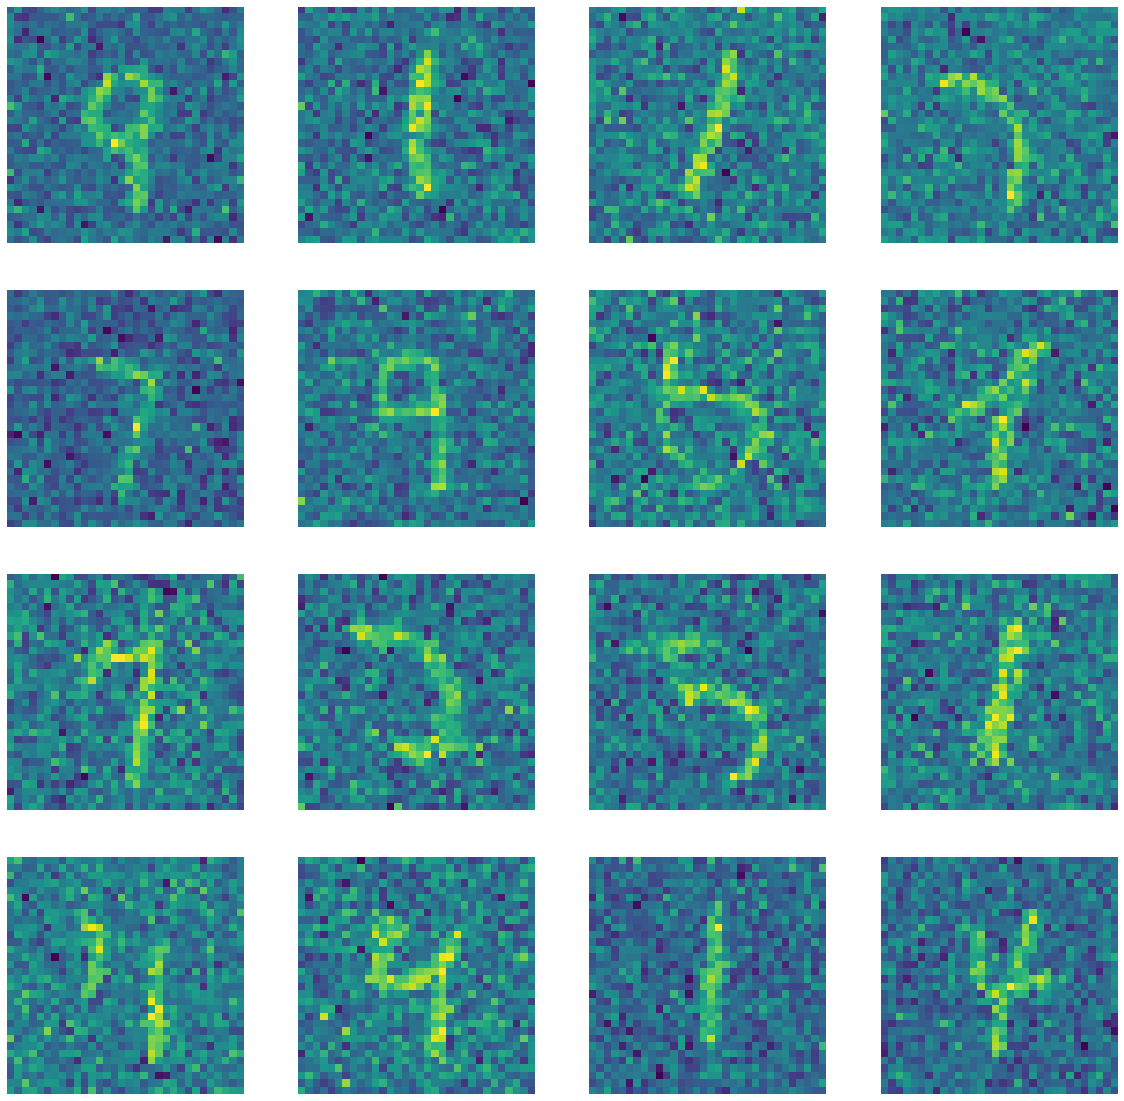

In [74]:
figure(figsize=(20,20))
for i in range(4):
  for j in range(4):
    subplot(4,4,4*i+j+1)
    imshow(samples[-1,(4*i+j)].reshape((32,32)))
    axis('off')

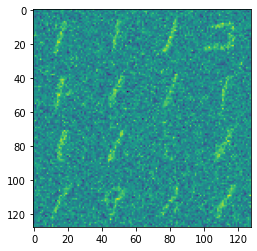

In [24]:
imshow(samples[-1].reshape((4,4,32,32)).transpose((0,2,1,3)).reshape((32*4,32*4))  )

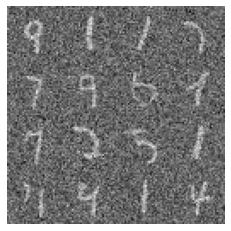

In [115]:
# Create a movie
files = []
for i in range(1000):
    plt.cla()
    imshow(samples[i*10].reshape((4,4,32,32)).transpose((0,2,1,3)).reshape((32*4,32*4)),cmap='gray',)
    axis('off')
    fname = '_tmp%03d.png' % i
    plt.savefig(fname,dpi=300)
    files.append(fname)

In [113]:
# To make a movie from these images:
#ffmpeg -r 60 -f image2  -i _tmp%3d.png -vcodec libx264 -crf 15 movie_mnist.mp4

Making movie animation.mpg - this may take a while


127